# Análisis Exploratorio de Datos (EDA) sobre datos de encuestas

Este notebook contiene un análisis completo de los datos de encuestas recopilados para el proyecto MIT LIFT LAB.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import MarkerCluster, HeatMap
import missingno as msno
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from wordcloud import WordCloud
import warnings
from collections import Counter
import re
from unidecode import unidecode
from rapidfuzz import fuzz, process
import nltk
from nltk.corpus import stopwords


warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
COLORS = px.colors.qualitative.Plotly

## 1. Carga de los datos

Empiezo por cargar los datos y ver los primeros registros del conjunto de datos:

In [2]:
df = pd.read_csv('../data/processed/clean_survey_to_analyze.csv')
df.head()

tipo_negocio  tiene_reja  anio_apertura  trabajadores_total  \
0                 Almacén       False         1980.0                 1.0   
1              Pescadería       False         2024.0                 1.0   
2              Dietéticas       False         1980.0                 2.0   
3  Confitería o Panadería       False         1989.0                 4.0   
4                 Almacén       False         2022.0                 5.0   

   trabajadores_salario_fijo expectativa_trabajadores_3m  \
0                        0.0            Permanezca igual   
1                        0.0                     Aumente   
2                        0.0            Permanezca igual   
3                        4.0            Permanezca igual   
4                        5.0                     Aumente   

  ventas_vs_mes_anterior                            razon_cambio_ventas  \
0                   Peor        Grandes empresarios aumentan los costos   
1                  Igual  Proximos meses: estacionalidad de las fiestas   
2                  Igual                                            NaN   
3                   Peor               Caída de ingesos de la poblacion   
4                  Igual                                    No contesta   

  expectativa_ventas_3m cambio_inventario expectativa_inventario_3m  \
0               Menores         Disminuyó                 Disminuya   
1               Mayores  Permaneció igual          Permanezca igual   
2               Mayores  Permaneció igual          Permanezca igual   
3               Menores  Permaneció igual                Incremente   
4               Iguales  Permaneció igual          Permanezca igual   

  percepcion_inventario    cambio_precios expectativa_precios_3m  \
0              Muy poco           Aumentó               Aumenten   
1  En su nivel correcto  Permaneció igual               Aumenten   
2  En su nivel correcto           Aumentó               Aumenten   
3  En su nivel correcto           Aumentó               Aumenten   
4  En su nivel correcto  Permaneció igual      Permanezcan igual   

  impacto_crimen impacto_falta_credito impacto_precio_bienes  \
0          Mucho                  Nada                 Mucho   
1           Poco                  Nada                 Mucho   
2           Poco                  Nada              Moderado   
3           Poco                  Nada                 Mucho   
4           Poco                  Nada                  Algo   

  impacto_competencia credito_bancos credito_proveedores credito_familia  \
0               Mucho          False                True           False   
1                Nada          False               False           False   
2                Nada          False               False           False   
3               Mucho          False               False           False   
4                Poco          False               False           False   

  credito_gobierno credito_privado credito_otro  \
0            False           False           No   
1            False           False          NaN   
2            False           False          NaN   
3            False           False          NaN   
4            False           False          NaN   

                    razon_sin_credito quiere_crecer  \
0  Las tasas de interés son muy altas          True   
1  Las tasas de interés son muy altas         False   
2              No necesito un crédito          True   
3              No necesito un crédito          True   
4              No necesito un crédito          True   

                         razon_no_crecer  \
0                                    NaN   
1  Porque está satisfecho con su negocio   
2                                    NaN   
3                                    NaN   
4                                    NaN   

                                nivel_digitalizacion  \
0  Básico: Usamos al menos una herramienta digita...   
1  Alto: La mayoría de nuestras operaciones usan ..

Veo información más detallada:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tipo_negocio                 923 non-null    object 
 1   tiene_reja                   923 non-null    bool   
 2   anio_apertura                853 non-null    float64
 3   trabajadores_total           853 non-null    float64
 4   trabajadores_salario_fijo    853 non-null    float64
 5   expectativa_trabajadores_3m  853 non-null    object 
 6   ventas_vs_mes_anterior       851 non-null    object 
 7   razon_cambio_ventas          703 non-null    object 
 8   expectativa_ventas_3m        851 non-null    object 
 9   cambio_inventario            848 non-null    object 
 10  expectativa_inventario_3m    846 non-null    object 
 11  percepcion_inventario        847 non-null    object 
 12  cambio_precios               844 non-null    object 
 13  expectativa_precios_

## 2. Análisis sobre datos faltantes

Al ser datos provenientes de una encuesta suele ocurrir que muchas preguntas quedan sin responder y por ende es común ver datos faltantes. Por lo tanto resulta pertinente realizar un análisis a profundidad sobre este tema en el conjunto de datos y así poder tener en mente con qué variables tratar y que acciones se pueden tomar:

In [4]:
# Filtro para valores faltantes
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Columna': missing_counts.index,
    'Valores Faltantes': missing_counts.values,
    'Porcentaje (%)': missing_percent.values
}).sort_values('Valores Faltantes', ascending=False)

# Generación de gráfico
missing_plot_df = missing_df[missing_df['Valores Faltantes'] > 0].head(20)
fig = px.bar(missing_plot_df, 
             x='Porcentaje (%)', 
             y='Columna',
             orientation='h',
             title='Top 20 Columnas con más valores faltantes',
             labels={'Porcentaje (%)': 'Porcentaje de Datos Faltantes (%)', 'Columna': 'Variables'},
             color='Porcentaje (%)',
             color_continuous_scale='Reds',
             text='Porcentaje (%)')

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(height=600, showlegend=False, yaxis={'categoryorder':'total ascending'})
fig.show()

Podemos también calcular la completitud general del conjunto de datos:

In [5]:
completitud = ((df.notna().sum().sum()) / (df.shape[0] * df.shape[1]) * 100).round(2)
print(f"\nCompletitud general del dataset: {completitud}%")


Completitud general del dataset: 80.8%


Con esto podemos ver que el conjunto de datos tiene aproximadamente 81% de completitud. Variables como `consumo_energia_kw_cash` (93%),  `razon_no_crecer` (80%) y `salario_reserva_text` (61%) tienen alta ausencia de datos, lo cual es esperable por el tipo de pregunta que representan (ver notebook 0). Las coordenadas tienen baja proporción de valores faltantes (12% ambas), lo cual es ideal para análisis geográfico y representa uno de los principales intereses del proyecto.

Podemos profundizar más en este análisis de valores faltantes y para se va a utilizar la librería **missingno**, la cual permite generar visualizaciones más detalladas sobre los valores faltantes. Vamos a empezar con una **matriz de valores faltantes**:

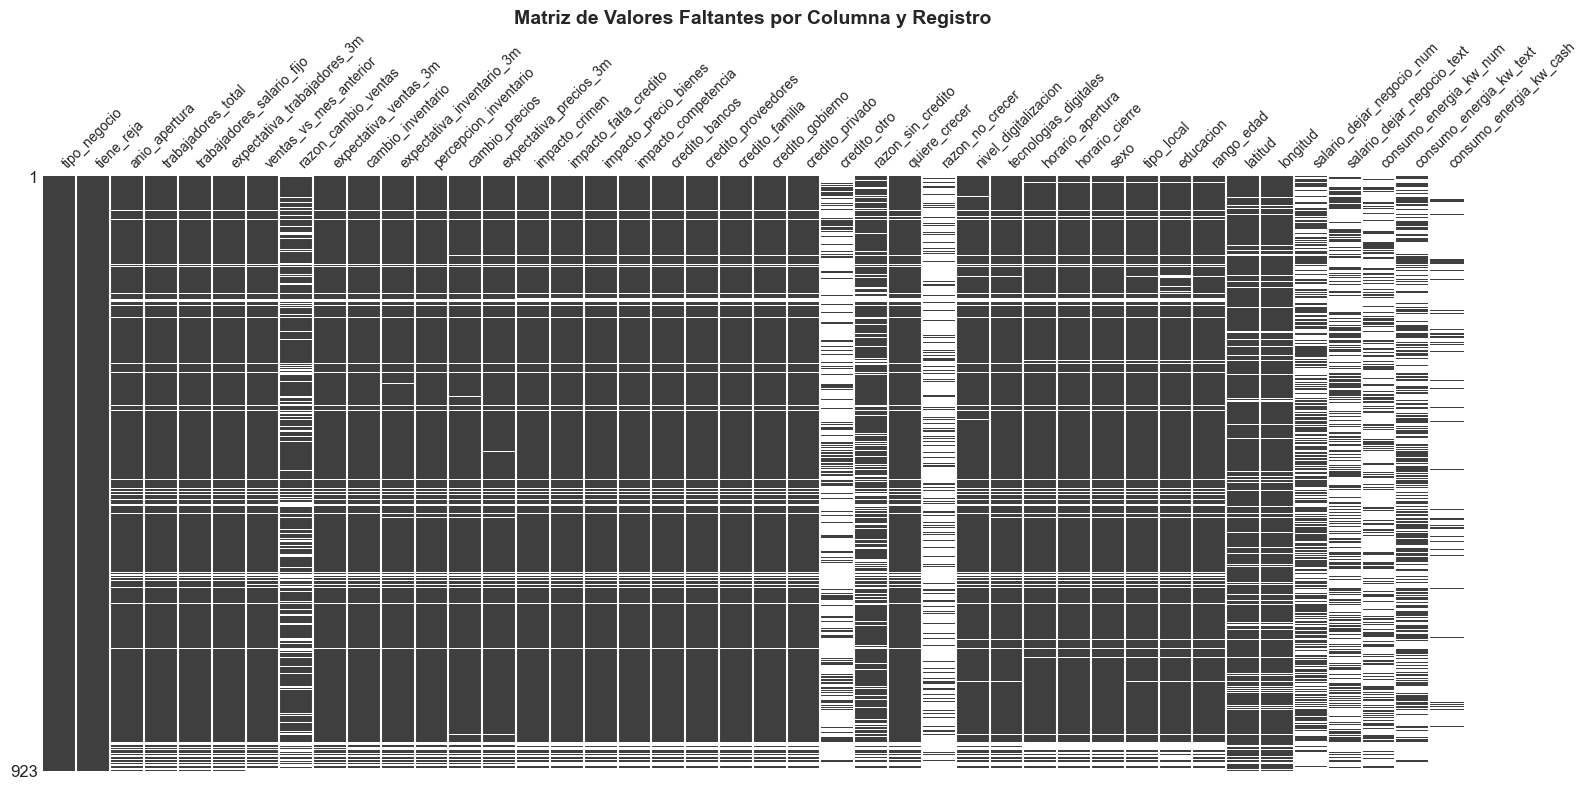

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
msno.matrix(df, ax=ax, fontsize=10, sparkline=False)
ax.set_title('Matriz de Valores Faltantes por Columna y Registro', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

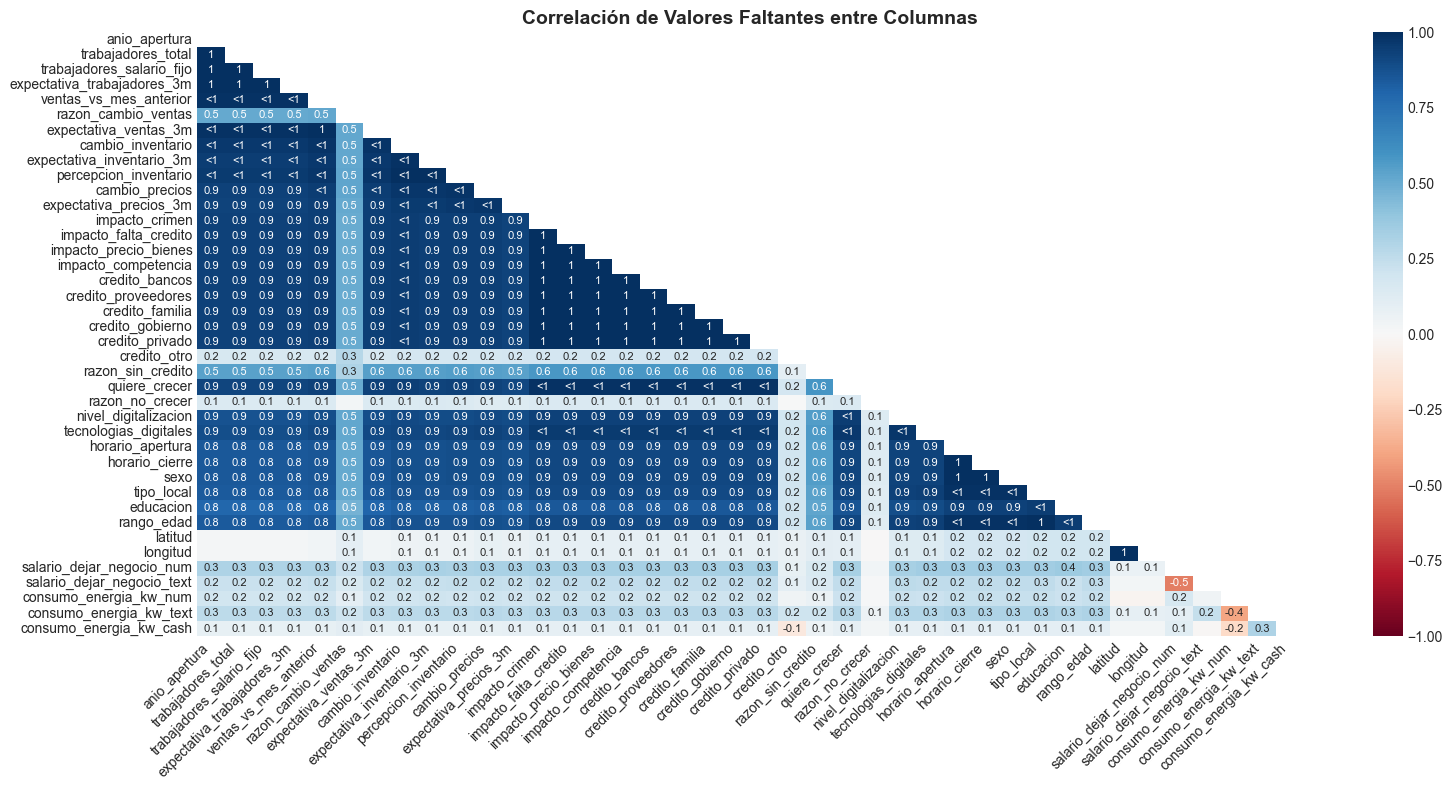

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
msno.heatmap(df, ax=ax, fontsize=10)
ax.set_title('Correlación de Valores Faltantes entre Columnas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Análisis univariado

Teniendo en mente como se distribuyen los valores faltantes en este conjunto de datos, el siguiente paso natural es analizar a las variables que tenemos disponibles. Al tener muchas variables vamos a limitarnos a analizar a las que consideremos como más importantes, pero como todo proceso a la hora de trabajar con datos, seguro habrán muchas iteraciones.

Empezamos por generar un gráfico de barras que muestre a los tipos de negocios que fueron encuestados:

In [8]:
tipo_negocio_counts = df['tipo_negocio'].value_counts()

fig = px.bar(tipo_negocio_counts, 
             x=tipo_negocio_counts.index, 
             y=tipo_negocio_counts.values,
             title='Distribución de Tipos de Negocios Encuestados',
             labels={'x': 'Tipo de Negocio', 'y': 'Cantidad de Negocios'},
             text=tipo_negocio_counts.values,
             color=tipo_negocio_counts.values,
             color_continuous_scale='Viridis')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(height=600, showlegend=False, xaxis_tickangle=-45)
fig.show()

Podemo ver que los almacenes, kioscos y verdulerías dominan la muestra y que hay buena diversidad con 15 tipos diferentes de negocios.

In [9]:
# Crear versión resumida de nivel_digitalizacion
def resumir_digitalizacion(texto):
    if pd.isna(texto):
        return 'Sin datos'
    texto_lower = str(texto).lower()
    if 'ninguno' in texto_lower:
        return 'Ninguno'
    elif 'básico' in texto_lower or 'basico' in texto_lower:
        return 'Básico'
    elif 'moderado' in texto_lower:
        return 'Moderado'
    elif 'alto' in texto_lower:
        return 'Alto'
    else:
        return 'Sin datos'

df['nivel_digital_resumido'] = df['nivel_digitalizacion'].apply(resumir_digitalizacion)
digital_counts = df['nivel_digital_resumido'].value_counts()

# Ordenar categorías
orden_digital = ['Ninguno', 'Básico', 'Moderado', 'Alto', 'Sin datos']
digital_counts = digital_counts.reindex([cat for cat in orden_digital if cat in digital_counts.index])

fig = px.bar(digital_counts, 
             x=digital_counts.index, 
             y=digital_counts.values,
             title='Nivel de Adopción Digital en Negocios',
             labels={'x': 'Nivel de Digitalización', 'y': 'Cantidad de Negocios'},
             text=digital_counts.values,
             color=digital_counts.values,
             color_continuous_scale='Viridis')

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(height=500, showlegend=False)
fig.show()

In [10]:
print(f"Proporcion de digitalización alto o moderado: {(491+162)/(len(df))}")
print(f"Proporcion de digitalización con valor faltante o ninguno: {(24+90)/(len(df))}")

Proporcion de digitalización alto o moderado: 0.7074756229685807
Proporcion de digitalización con valor faltante o ninguno: 0.12351029252437704


Aquí podemos ver que el 71% tiene nivel moderado o alto de digitalización. Solo 12% sin digitalización o valor faltante, lo que indica buena adopción tecnológica.

In [11]:
# 3.3 Variables numéricas clave
variables_numericas = ['anio_apertura', 'trabajadores_total', 'trabajadores_salario_fijo', 
                       'salario_dejar_negocio_num', 'consumo_energia_kw_num', 'consumo_energia_kw_cash', 'edad_negocio']

fig = make_subplots(rows=3, cols=3, 
                    subplot_titles=['Año de Apertura', 'Trabajadores Totales', 'Trabajadores con Salario',
                                   'Salario para dejar negocio (ARS)', 'Consumo Energético (kW)', 'Edad del Negocio', 'Gasto de consumo Energético (ARS)'],
                    vertical_spacing=0.12, horizontal_spacing=0.1)

# Año de apertura
df_filtered = df[df['anio_apertura'].notna()]
fig.add_trace(go.Histogram(x=df_filtered['anio_apertura'], name='Año Apertura', 
                           marker_color='lightblue', showlegend=False), row=1, col=1)

# Trabajadores
fig.add_trace(go.Histogram(x=df[df['trabajadores_total'].notna()]['trabajadores_total'], 
                           name='Trabajadores', marker_color='lightgreen', showlegend=False), row=1, col=2)

# Trabajadores con salario
fig.add_trace(go.Histogram(x=df[df['trabajadores_salario_fijo'].notna()]['trabajadores_salario_fijo'], 
                           name='Con Salario', marker_color='coral', showlegend=False), row=1, col=3)

# Salario reserva (log scale para mejor visualización)
salario_data = df[df['salario_dejar_negocio_num'] > 0]['salario_dejar_negocio_num']
fig.add_trace(go.Histogram(x=salario_data, name='Salario', 
                           marker_color='gold', showlegend=False), row=2, col=1)

# Consumo energético
consumo_data = df[df['consumo_energia_kw_num'].notna()]['consumo_energia_kw_num']
fig.add_trace(go.Histogram(x=consumo_data, name='Consumo kW', 
                           marker_color='mediumpurple', showlegend=False), row=2, col=2)

# Gasto monetario en consumo energético
gasto_data = df[df['consumo_energia_kw_cash'].notna()]['consumo_energia_kw_cash']
fig.add_trace(go.Histogram(x=gasto_data, name='Gasto Consumo Energético', 
                           marker_color='darkorange', showlegend=False), row=3, col=1)

# Edad del negocio
df['edad_negocio'] = 2025 - df['anio_apertura']
edad_data = df[df['edad_negocio'].notna()]['edad_negocio']
fig.add_trace(go.Histogram(x=edad_data, name='Edad Negocio', 
                           marker_color='lightcoral', showlegend=False), row=2, col=3)

fig.update_layout(height=700, title_text='Distribuciones de Variables Numéricas Clave', 
                  showlegend=False)
fig.show()

In [12]:
print("\nEstadísticas Descriptivas:")
print(df[variables_numericas].describe().round(2))


Estadísticas Descriptivas:
       anio_apertura  trabajadores_total  trabajadores_salario_fijo  \
count         853.00              853.00                     853.00   
mean         2012.95                3.19                       2.28   
std            12.94                2.18                       2.42   
min          1980.00                1.00                       0.00   
25%          2006.00                2.00                       0.00   
50%          2018.00                2.00                       2.00   
75%          2023.00                4.00                       3.00   
max          2025.00               10.00                      10.00   

       salario_dejar_negocio_num  consumo_energia_kw_num  \
count                     491.00                  290.00   
mean                  2991666.48                 1345.63   
std                   5686387.53                 1536.78   
min                         0.00                    0.00   
25%                   1000000.00

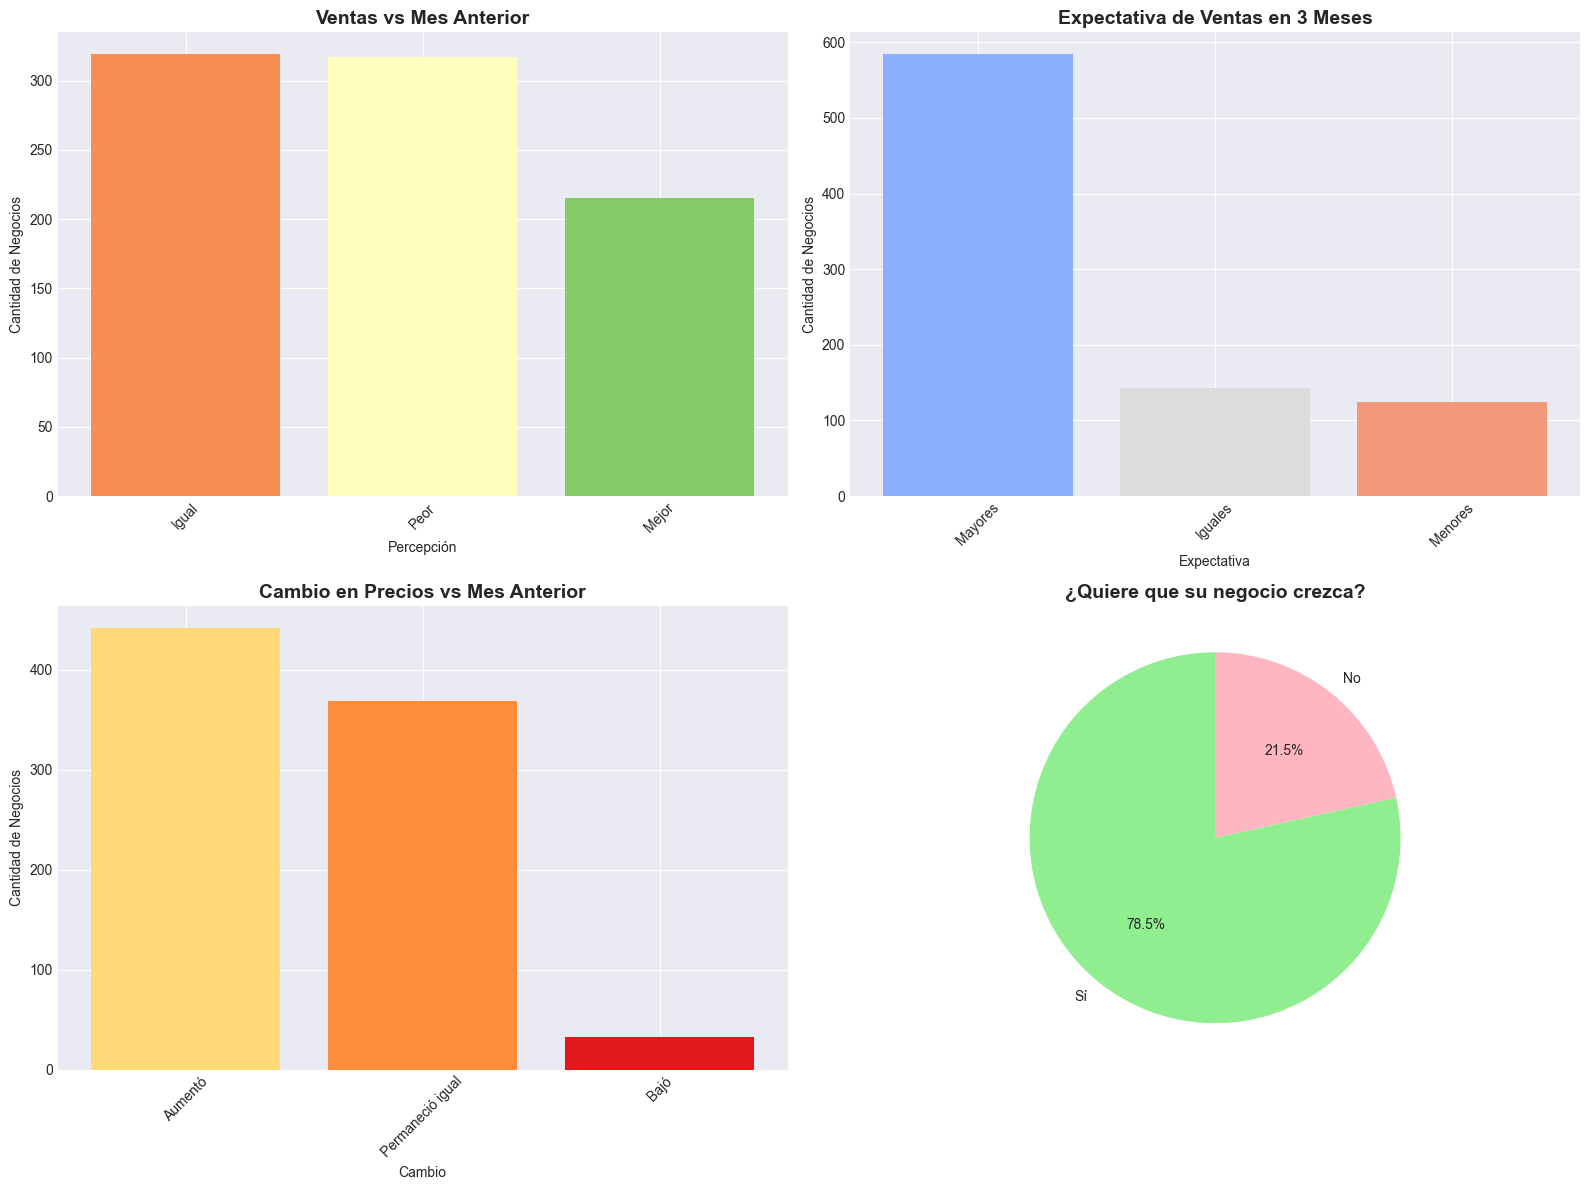

In [13]:
# 3.4 Análisis de Expectativas y Percepciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ventas vs mes anterior
ventas_counts = df['ventas_vs_mes_anterior'].value_counts()
axes[0, 0].bar(ventas_counts.index, ventas_counts.values, color=sns.color_palette("RdYlGn", len(ventas_counts)))
axes[0, 0].set_title('Ventas vs Mes Anterior', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Percepción')
axes[0, 0].set_ylabel('Cantidad de Negocios')
axes[0, 0].tick_params(axis='x', rotation=45)

# Expectativa ventas 3 meses
exp_ventas = df['expectativa_ventas_3m'].value_counts()
axes[0, 1].bar(exp_ventas.index, exp_ventas.values, color=sns.color_palette("coolwarm", len(exp_ventas)))
axes[0, 1].set_title('Expectativa de Ventas en 3 Meses', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Expectativa')
axes[0, 1].set_ylabel('Cantidad de Negocios')
axes[0, 1].tick_params(axis='x', rotation=45)

# Cambio de precios
precios = df['cambio_precios'].value_counts()
axes[1, 0].bar(precios.index, precios.values, color=sns.color_palette("YlOrRd", len(precios)))
axes[1, 0].set_title('Cambio en Precios vs Mes Anterior', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Cambio')
axes[1, 0].set_ylabel('Cantidad de Negocios')
axes[1, 0].tick_params(axis='x', rotation=45)

# Quiere crecer
crecer_counts = df['quiere_crecer'].value_counts()
axes[1, 1].pie(crecer_counts.values, labels=['Sí' if x else 'No' for x in crecer_counts.index], 
               autopct='%1.1f%%', colors=['#90EE90', '#FFB6C1'], startangle=90)
axes[1, 1].set_title('¿Quiere que su negocio crezca?', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Análisis de texto (NLP)

Para todas las variables que contienen texto presentes en nuestro conjunto de datos, algo básico pero pertinente que podemos analizar es la frecuencia de palabras. Para eso vamos a generar visualizaciones de nubes de palabras sobre cada una de estas variables y ver que patrones encontramos:

In [14]:
def limpiar_texto_nlp(texto):
    """Limpia y normaliza texto para análisis NLP"""
    if pd.isna(texto):
        return ""
    texto = str(texto).lower()
    texto = unidecode(texto)  # Quitar acentos
    texto = re.sub(r'[^\w\s]', ' ', texto)  # Quitar puntuación
    texto = re.sub(r'\s+', ' ', texto).strip()  # Normalizar espacios
    return texto

def generar_nube_palabras(dataframe, nombre_columna, titulo=None, figsize=(16, 8)):
    """
    Genera una nube de palabras para una columna de texto del dataframe.
    
    Parámetros:
    -----------
    dataframe : pandas.DataFrame
        DataFrame que contiene la columna de texto
    nombre_columna : str
        Nombre de la columna con texto a analizar
    titulo : str, optional
        Título personalizado para el gráfico. Si es None, se genera automáticamente.
    figsize : tuple, optional
        Tamaño de la figura (ancho, alto). Default: (16, 8)
    
    Returns:
    --------
    None. Muestra el gráfico de nube de palabras.
    """
    stopwords_es = set(stopwords.words('spanish'))
    
    # Obtener datos de la columna
    datos_texto = dataframe[nombre_columna].dropna()
    total_respuestas = len(datos_texto)
    
    print(f"Total de respuestas en '{nombre_columna}': {total_respuestas}")
    
    # Limpiar y concatenar todo el texto
    texto_completo = ' '.join([limpiar_texto_nlp(x) for x in datos_texto])
    
    # Crear figura
    fig, ax = plt.subplots(figsize=figsize)
    
    if len(texto_completo) > 0:
        # Generar nube de palabras
        wordcloud = WordCloud(width=1600, height=800, 
                              background_color='white',
                              stopwords=stopwords_es,
                              colormap='viridis',
                              max_words=100,
                              relative_scaling=0.5,
                              min_font_size=10).generate(texto_completo)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        
        # Título automático o personalizado
        if titulo is None:
            titulo = f'Nube de Palabras: {nombre_columna.replace("_", " ").title()}'
        ax.set_title(titulo, fontsize=18, fontweight='bold', pad=20)
    else:
        ax.text(0.5, 0.5, 'No hay suficiente texto para generar nube de palabras', 
                ha='center', va='center', fontsize=14)
        ax.axis('off')
        if titulo:
            ax.set_title(titulo, fontsize=18, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    print(f"\n{'='*80}\n")

# Variables de texto identificadas en el dataset
variables_texto = ['razon_cambio_ventas', 'razon_no_crecer', 'salario_dejar_negocio_text', 
                   'consumo_energia_kw_text', 'razon_sin_credito']


                         ANÁLISIS DE TEXTO - NUBES DE PALABRAS

Total de respuestas en 'razon_cambio_ventas': 703


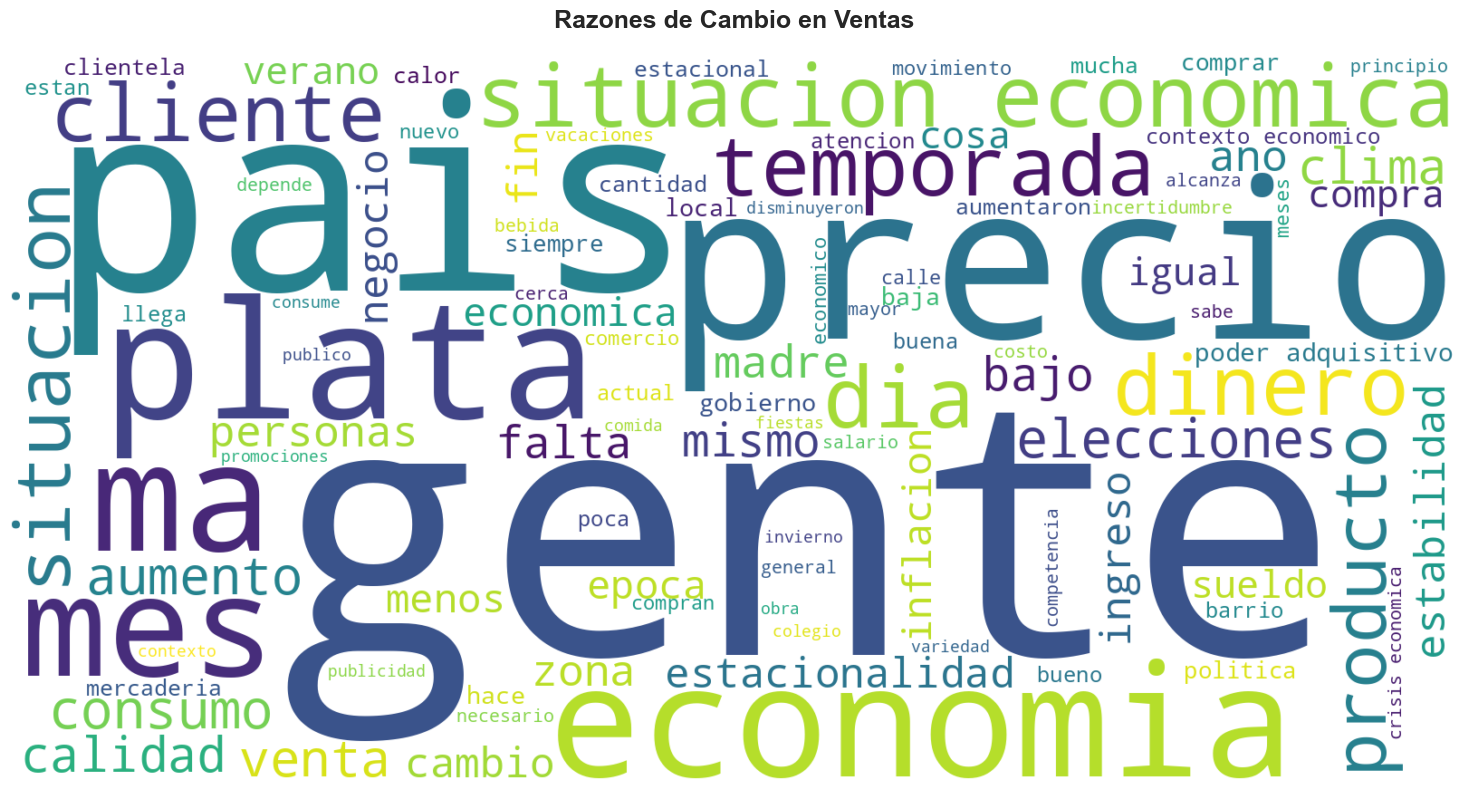



Total de respuestas en 'razon_no_crecer': 181


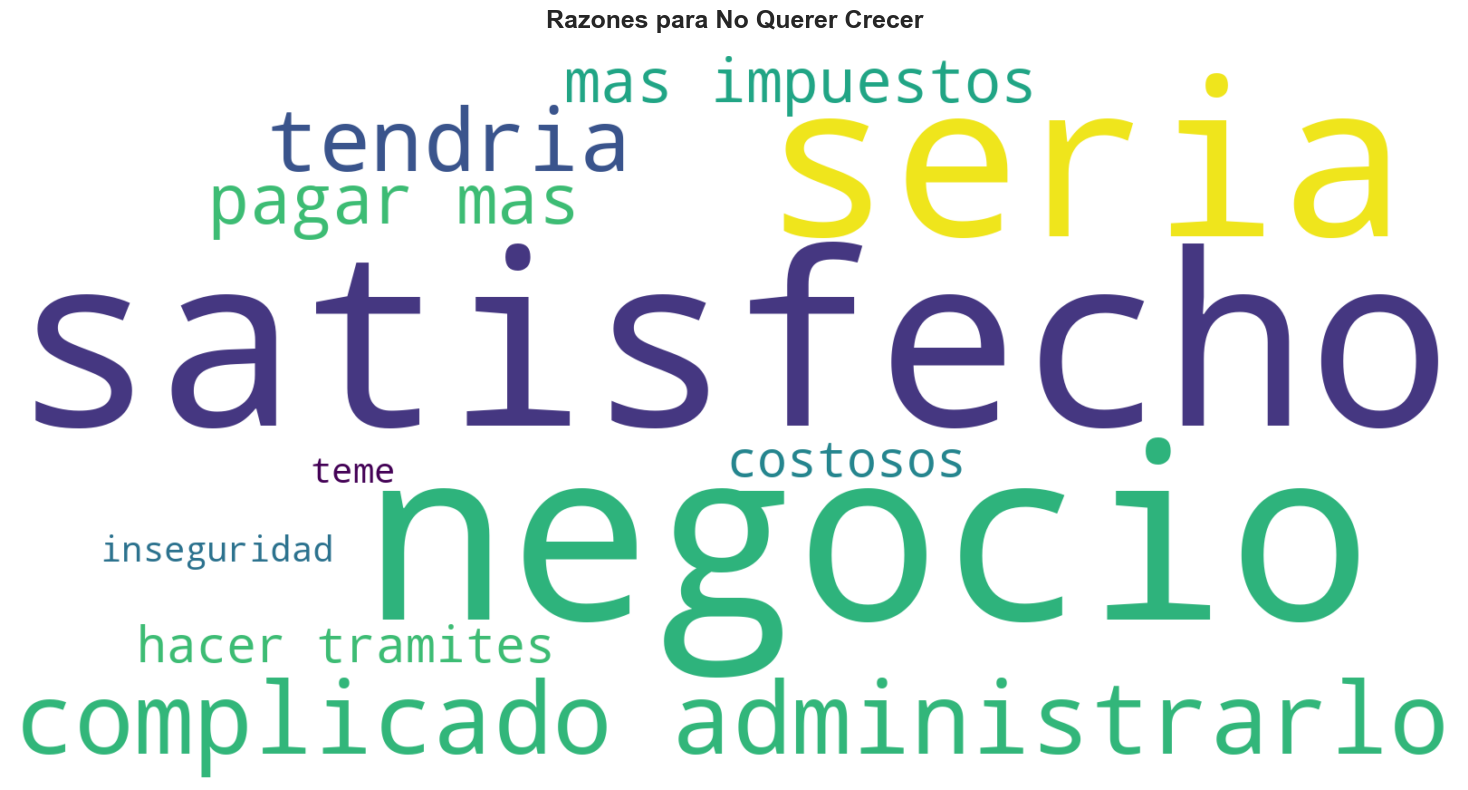



Total de respuestas en 'salario_dejar_negocio_text': 353


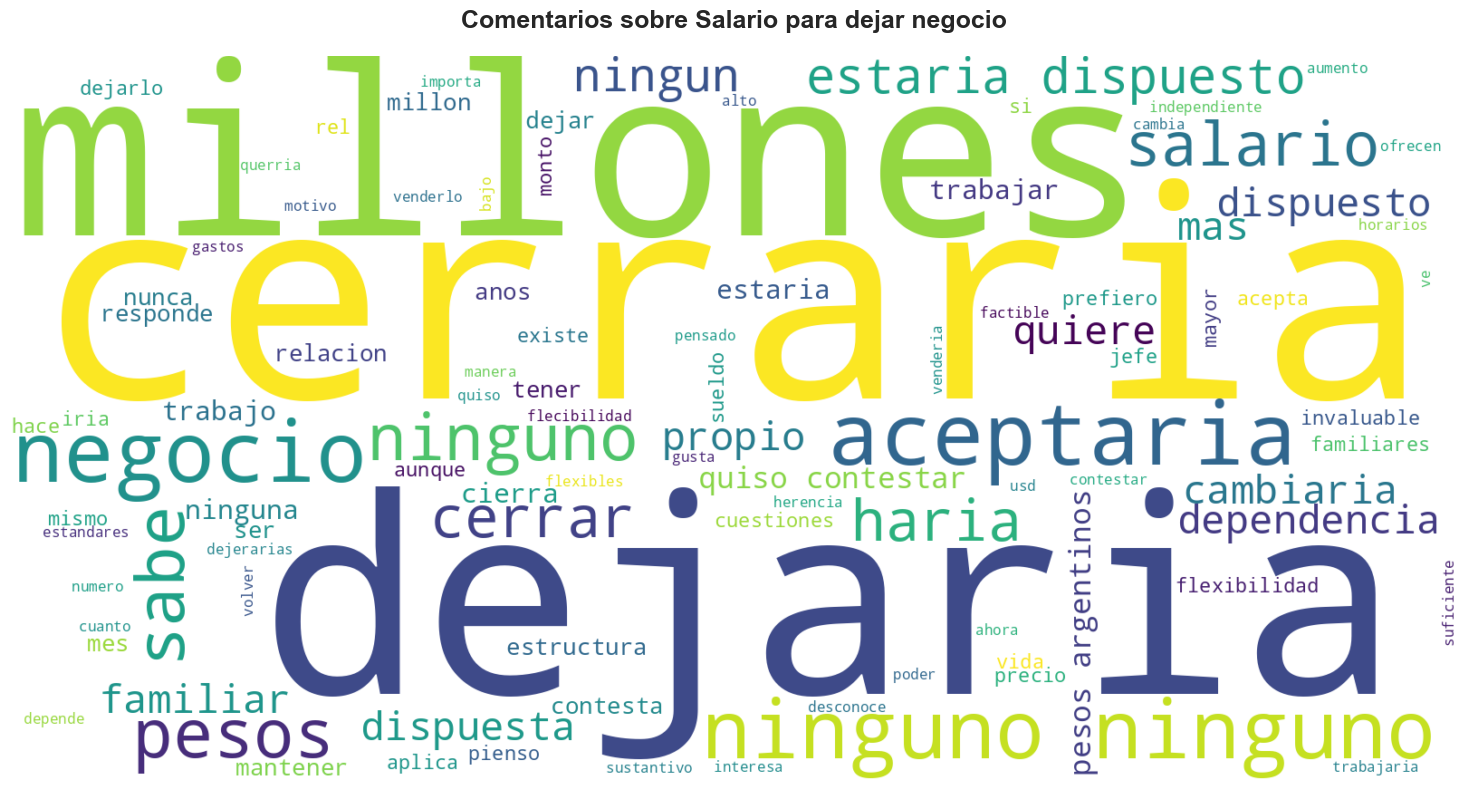



Total de respuestas en 'consumo_energia_kw_text': 416


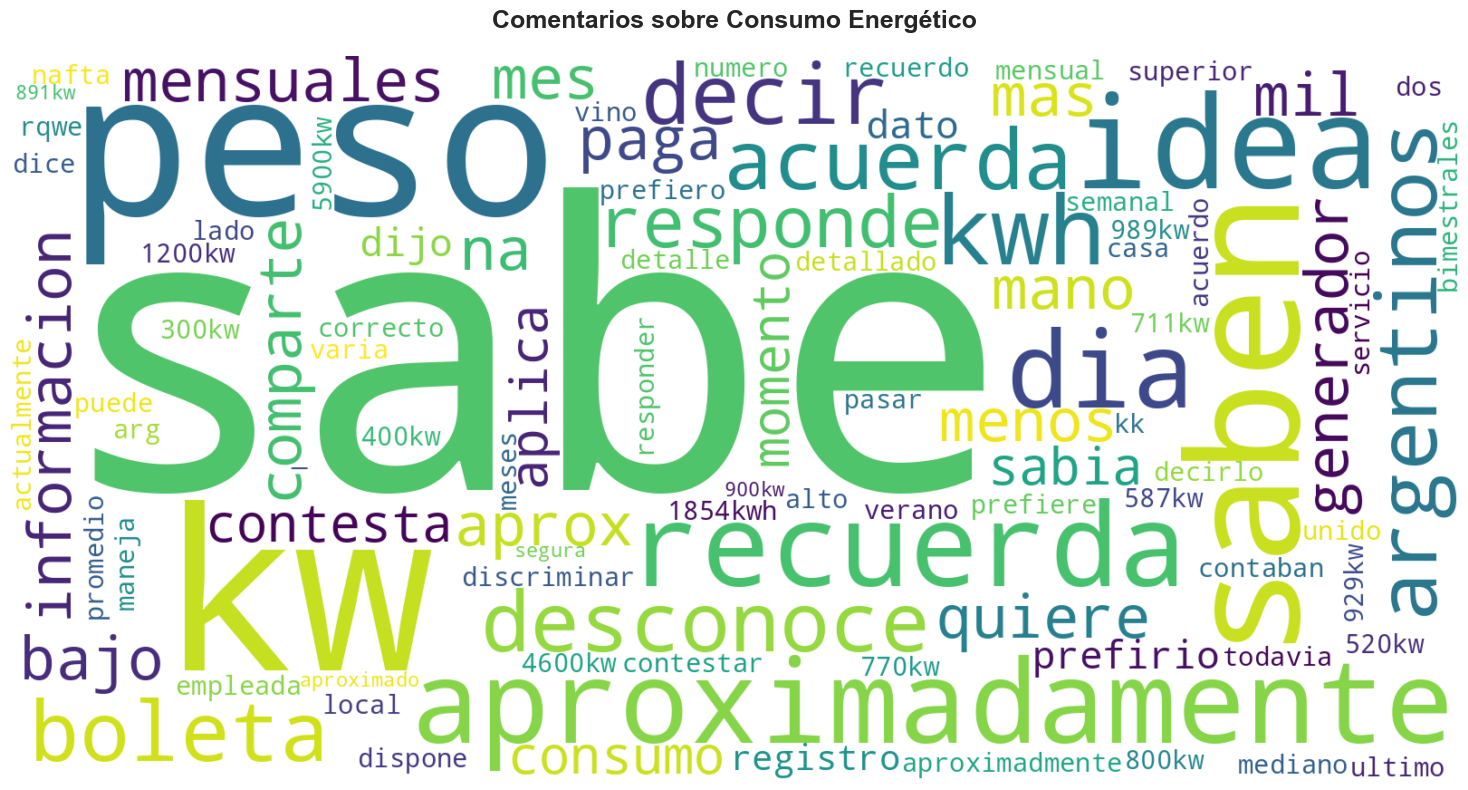



Total de respuestas en 'razon_sin_credito': 722


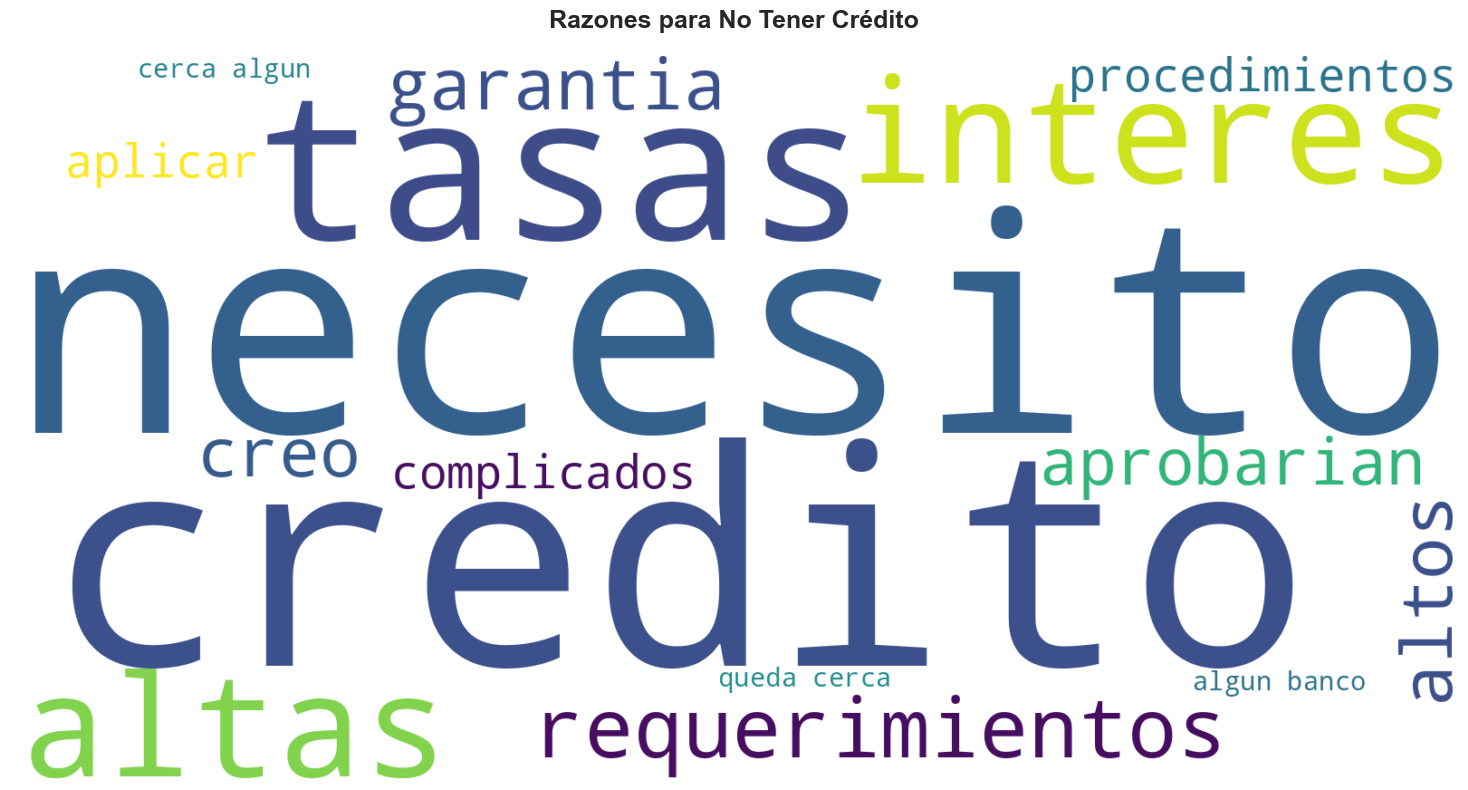

In [15]:
# Diccionario con títulos personalizados para cada variable
titulos_personalizados = {
    'razon_cambio_ventas': 'Razones de Cambio en Ventas',
    'razon_no_crecer': 'Razones para No Querer Crecer',
    'salario_dejar_negocio_text': 'Comentarios sobre Salario para dejar negocio',
    'consumo_energia_kw_text': 'Comentarios sobre Consumo Energético',
    'razon_sin_credito': 'Razones para No Tener Crédito'
}

print("\n" + "="*80)
print(" "*25 + "ANÁLISIS DE TEXTO - NUBES DE PALABRAS")
print("="*80 + "\n")

# Aplicar la función a cada variable de texto
for variable in variables_texto:
    if variable in df.columns:
        titulo = titulos_personalizados.get(variable, None)
        generar_nube_palabras(df, variable, titulo=titulo)
    else:
        print(f"Variable '{variable}' no encontrada en el dataset\n")

## 5. Análisis Geográfico

In [16]:
# Crear copia para no modificar el original
df_temp = df.copy()

# Verificar y limpiar latitudes
# Buenos Aires: latitud entre -35 y -34 (aprox)
df_temp['latitud_limpia'] = df_temp['latitud'].copy()
df_temp['longitud_limpia'] = df_temp['longitud'].copy()

# Corregir valores que están como enteros grandes (sin punto decimal)
mask_lat_grande = df_temp['latitud'].abs() > 100
if mask_lat_grande.any():
    df_temp.loc[mask_lat_grande, 'latitud_limpia'] = df_temp.loc[mask_lat_grande, 'latitud'] / 10000

mask_lon_grande = df_temp['longitud'].abs() > 100
if mask_lon_grande.any():
    df_temp.loc[mask_lon_grande, 'longitud_limpia'] = df_temp.loc[mask_lon_grande, 'longitud'] / 10000

# Corregir signos incorrectos (latitud de Buenos Aires es negativa, longitud también)
mask_lat_positiva = df_temp['latitud_limpia'] > 0
if mask_lat_positiva.any():
    df_temp.loc[mask_lat_positiva, 'latitud_limpia'] = -df_temp.loc[mask_lat_positiva, 'latitud_limpia']

# Filtrar coordenadas válidas para Buenos Aires y alrededores
# Latitud: -36 a -33, Longitud: -59 a -57
df_geo = df_temp[
    df_temp['latitud_limpia'].between(-36, -33) & 
    df_temp['longitud_limpia'].between(-59, -57)
].copy()

# Usar coordenadas limpias
df_geo['latitud'] = df_geo['latitud_limpia']
df_geo['longitud'] = df_geo['longitud_limpia']

print(f"\nNegocios con coordenadas válidas: {len(df_geo)} de {len(df)}")
print(f"   Porcentaje con geolocalización: {len(df_geo)/len(df)*100:.1f}%")
print(f"\nRangos geográficos validados:")
print(f"   Latitud: {df_geo['latitud'].min():.4f} a {df_geo['latitud'].max():.4f}")
print(f"   Longitud: {df_geo['longitud'].min():.4f} a {df_geo['longitud'].max():.4f}")
print(f"\nCoordenadas validadas para región de Buenos Aires")


Negocios con coordenadas válidas: 687 de 923
   Porcentaje con geolocalización: 74.4%

Rangos geográficos validados:
   Latitud: -34.9113 a -34.3333
   Longitud: -58.8300 a -58.1819

Coordenadas validadas para región de Buenos Aires


In [17]:
# 5.2 Mapa interactivo con Plotly - Todos los negocios
# Filtrar registros válidos para el mapa
df_geo_plot = df_geo[
    df_geo['trabajadores_total'].notna() & 
    df_geo['latitud'].notna() & 
    df_geo['longitud'].notna()
].copy()
# Calcular centro del mapa
center_lat = df_geo_plot['latitud'].mean()
center_lon = df_geo_plot['longitud'].mean()
fig = px.scatter_mapbox(df_geo_plot, 
                        lat='latitud', 
                        lon='longitud',
                        color='tipo_negocio',
                        size='trabajadores_total',
                        hover_name='tipo_negocio',
                        hover_data={
                            'nivel_digitalizacion': True,
                            'trabajadores_total': True,
                            'latitud': ':.4f',
                            'longitud': ':.4f',
                            'tipo_negocio': False
                        },
                        title='Distribución Geográfica de Negocios Encuestados',
                        zoom=11,
                        center={"lat": center_lat, "lon": center_lon},
                        height=700,
                        color_discrete_sequence=px.colors.qualitative.Bold)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [18]:
# 5.3 Mapa con Folium (más detallado)

# Calcular centro del mapa
center_lat = df_geo['latitud'].mean()
center_lon = df_geo['longitud'].mean()

# Crear mapa base
mapa = folium.Map(location=[center_lat, center_lon], 
                  zoom_start=11,
                  tiles='OpenStreetMap')

# Añadir cluster de marcadores
marker_cluster = MarkerCluster().add_to(mapa)

# Definir colores por tipo de negocio
tipo_colores = {
    'Almacén': 'blue',
    'Kiosko': 'green',
    'Carnicería': 'red',
    'Verdulería': 'lightgreen',
    'Confitería o Panadería': 'orange',
    'Cafeterías': 'cadetblue',
    'Bares y pequeños restaurantes': 'purple',
    'Pescadería': 'lightblue',
    'Dietéticas': 'pink',
    'Fiambrería': 'darkred',
    'Granja': 'beige',
    'Frutería': 'darkgreen',
    'Cervecería': 'gray',
    'Heladería': 'lightgray',
    'Huevería': 'yellow'
}

# Contador para verificar
marcadores_agregados = 0

# Añadir marcadores
for idx, row in df_geo.iterrows():
    # Verificar que las coordenadas sean válidas
    if pd.notna(row['latitud']) and pd.notna(row['longitud']):
        color = tipo_colores.get(row['tipo_negocio'], 'gray')
        
        # Construir información del popup
        digital_info = row['nivel_digitalizacion'] if pd.notna(row['nivel_digitalizacion']) else 'N/A'
        trabajadores_info = int(row['trabajadores_total']) if pd.notna(row['trabajadores_total']) else 'N/A'
        anio_info = int(row['anio_apertura']) if pd.notna(row['anio_apertura']) else 'N/A'
        
        popup_html = f"""
        <div style="font-family: Arial; font-size: 12px; min-width: 200px;">
            <b style="font-size: 14px; color: #333;">{row['tipo_negocio']}</b><br><br>
            <b>Digitalización:</b> {digital_info}<br>
            <b>Trabajadores:</b> {trabajadores_info}<br>
            <b>Año apertura:</b> {anio_info}
        </div>
        """
        
        folium.Marker(
            location=[row['latitud'], row['longitud']],
            popup=folium.Popup(popup_html, max_width=400),
            tooltip=f"{row['tipo_negocio']}",
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(marker_cluster)
        
        marcadores_agregados += 1
# Añadir leyenda
leyenda_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 220px; height: auto; 
            background-color: white; z-index:9999; font-size:11px;
            border:2px solid grey; border-radius: 5px; padding: 10px;
            box-shadow: 0 0 15px rgba(0,0,0,0.2);">
<b style="font-size: 13px;">Tipos de Negocio</b><br><br>
'''
for tipo, color in list(tipo_colores.items())[:10]:
    leyenda_html += f'<i class="fa fa-map-marker fa-lg" style="color:{color}"></i>&nbsp;{tipo}<br>'
leyenda_html += '</div>'

mapa.get_root().html.add_child(folium.Element(leyenda_html))

# Guardar mapa
mapa.save('../data/processed/mapa_negocios.html')

# Mostrar mapa en notebook
mapa

## 6. Clustering geográfico y segmentación por zonas

In [19]:
# 6.1 Clustering geográfico con DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Preparar datos para clustering
coords = df_geo[['latitud', 'longitud']].values

# DBSCAN para encontrar clusters geográficos
# eps en grados (aprox 0.01 grados ≈ 1.1 km en Argentina)
dbscan = DBSCAN(eps=0.02, min_samples=3)
df_geo['cluster_geografico'] = dbscan.fit_predict(coords)

# Estadísticas de clusters
n_clusters = len(set(df_geo['cluster_geografico'])) - (1 if -1 in df_geo['cluster_geografico'] else 0)
n_noise = list(df_geo['cluster_geografico']).count(-1)

print(f"Clustering Geográfico con DBSCAN:")
print(f"   Clusters identificados: {n_clusters}")
print(f"   Puntos no asignados (ruido): {n_noise}")
print(f"\nDistribución de negocios por cluster:")
print(df_geo['cluster_geografico'].value_counts().sort_index())

Clustering Geográfico con DBSCAN:
   Clusters identificados: 17
   Puntos no asignados (ruido): 20

Distribución de negocios por cluster:
cluster_geografico
-1      20
 0      12
 1     427
 2     110
 3       4
 4      21
 5      16
 6       7
 7       9
 8      28
 9       4
 10      3
 11      8
 12      3
 13      3
 14      8
 15      4
Name: count, dtype: int64


Podemos ver que DBSCAN identificó 17 zonas geográficas distintas. El cluster 1 es el más grande con 427 negocios (probablemente Capital/CABA). Solo 20 negocios están dispersos geográficamente (ruido). Las coordenadas fueron validadas y corregidas para la región de Buenos Aires.

In [20]:
# 6.2 Visualizar clusters en mapa
df_geo_cluster = df_geo[
    df_geo['trabajadores_total'].notna() & 
    df_geo['cluster_geografico'].notna()
].copy()

# Calcular centro
center_lat = df_geo_cluster['latitud'].mean()
center_lon = df_geo_cluster['longitud'].mean()

fig = px.scatter_mapbox(df_geo_cluster, 
                        lat='latitud', 
                        lon='longitud',
                        color='cluster_geografico',
                        size='trabajadores_total',
                        hover_name='tipo_negocio',
                        hover_data={
                            'nivel_digitalizacion': True,
                            'cluster_geografico': True,
                            'trabajadores_total': True,
                            'tipo_negocio': False
                        },
                        title='Clusters Geográficos de Negocios (DBSCAN)',
                        zoom=9,
                        center={"lat": center_lat, "lon": center_lon},
                        height=700,
                        color_continuous_scale='Viridis')

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

## 7. Análisis bivariado

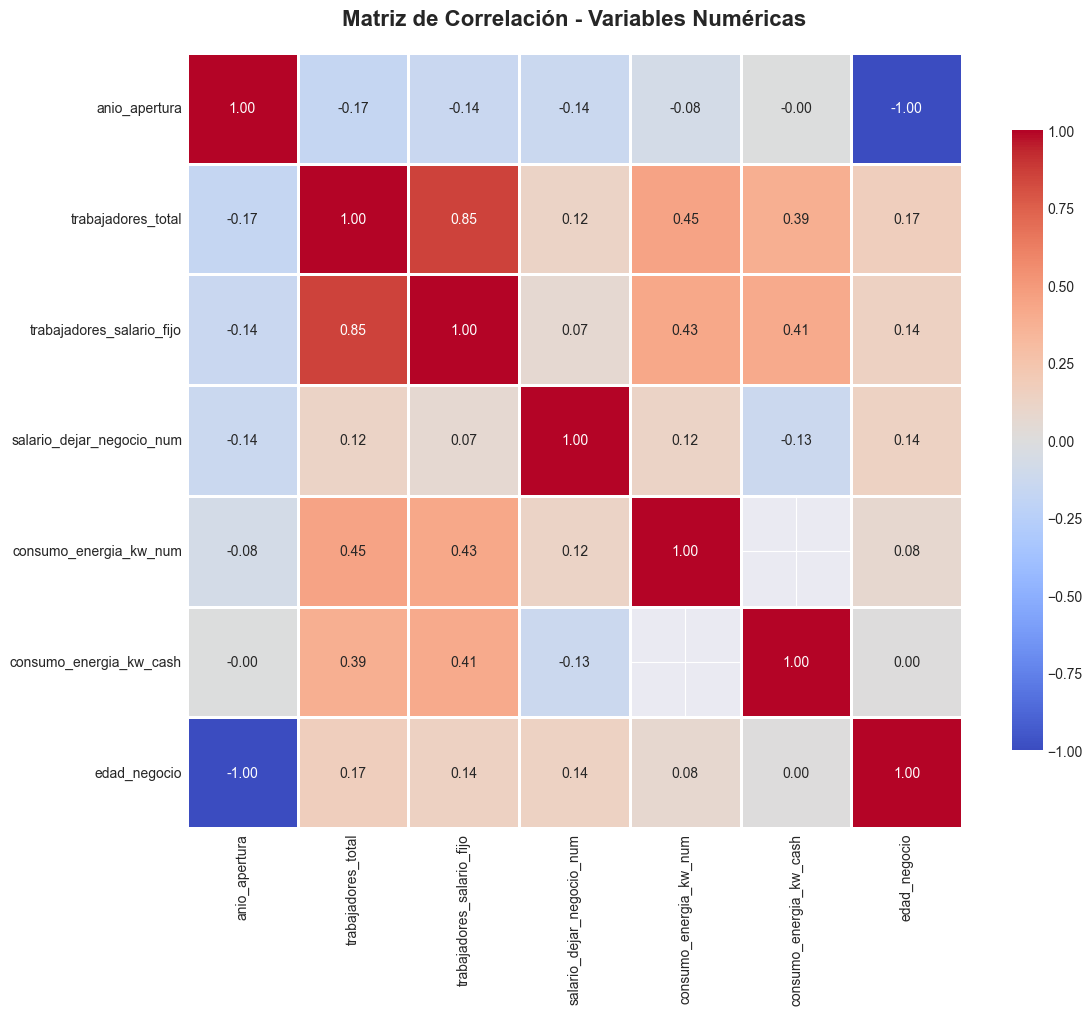

In [21]:
df_numeric = df[variables_numericas].copy()
correlation_matrix = df_numeric.corr()

# Visualizar con heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Matriz de Correlación - Variables Numéricas', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

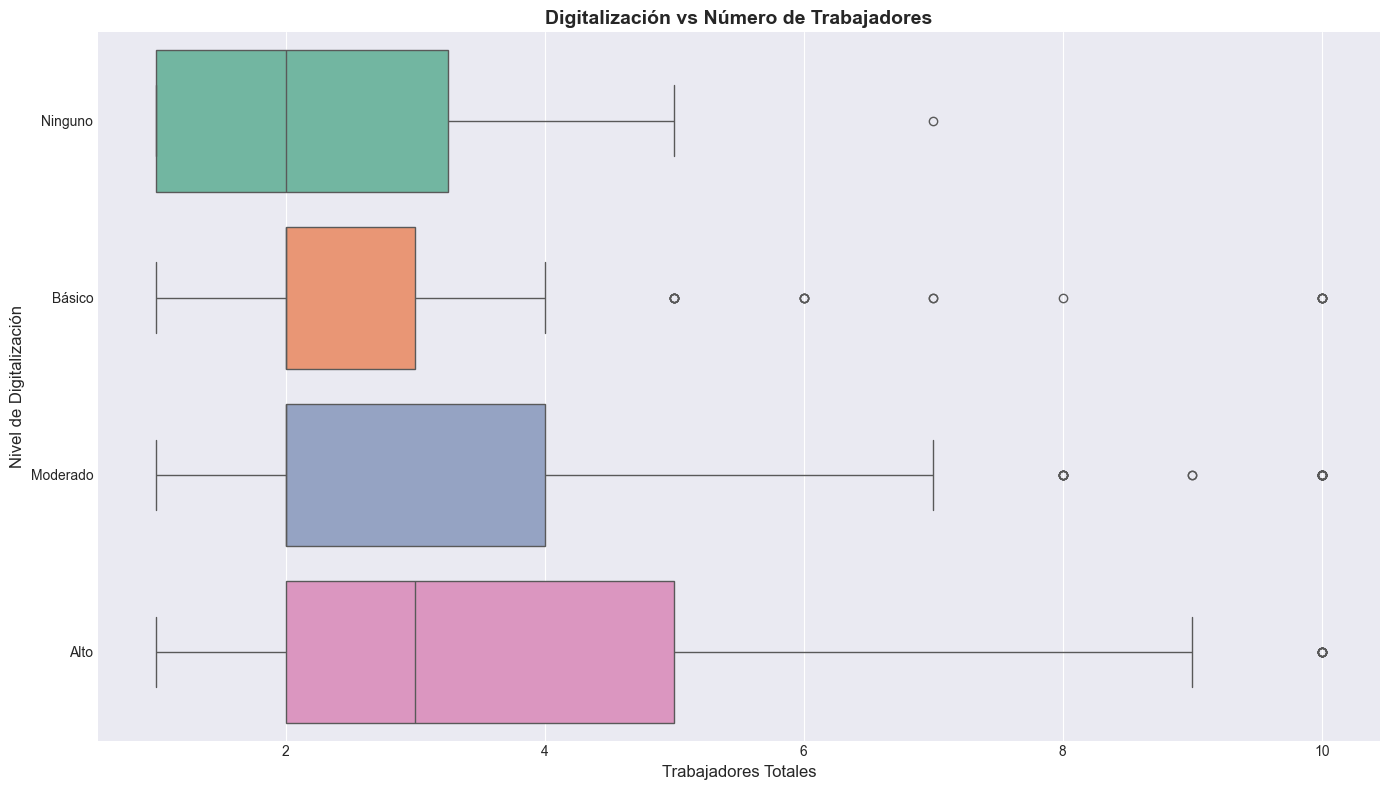

In [22]:
# 7.2.1 Digitalización vs Trabajadores
digital_order = ['Ninguno: No usamos ninguna herramienta digital (todos los procesos son manuales).',
                'Básico: Usamos al menos una herramienta digital básica (ej. un celular o una app de mensajería) para algunas tareas.',
                'Moderado: Usamos algunas tecnologías digitales (ej. aceptamos pagos con tarjeta/QR o usamos un sistema POS sencillo o app de pedidos).',
                'Alto: La mayoría de nuestras operaciones usan sistemas digitales (ej. software de inventario, caja electrónica, pedidos en línea).']

# Etiquetas cortas para el gráfico
digital_labels = ['Ninguno', 'Básico', 'Moderado', 'Alto']

fig, ax = plt.subplots(figsize=(14, 8))

df_plot = df[df['nivel_digitalizacion'].notna() & df['trabajadores_total'].notna()]
sns.boxplot(data=df_plot, y='nivel_digitalizacion', x='trabajadores_total', 
            order=digital_order, ax=ax, palette='Set2')
ax.set_title('Digitalización vs Número de Trabajadores', fontsize=14, fontweight='bold')
ax.set_ylabel('Nivel de Digitalización', fontsize=12)
ax.set_xlabel('Trabajadores Totales', fontsize=12)

# Reemplazar etiquetas del eje Y con versiones cortas
ax.set_yticklabels(digital_labels)

plt.tight_layout()
plt.show()


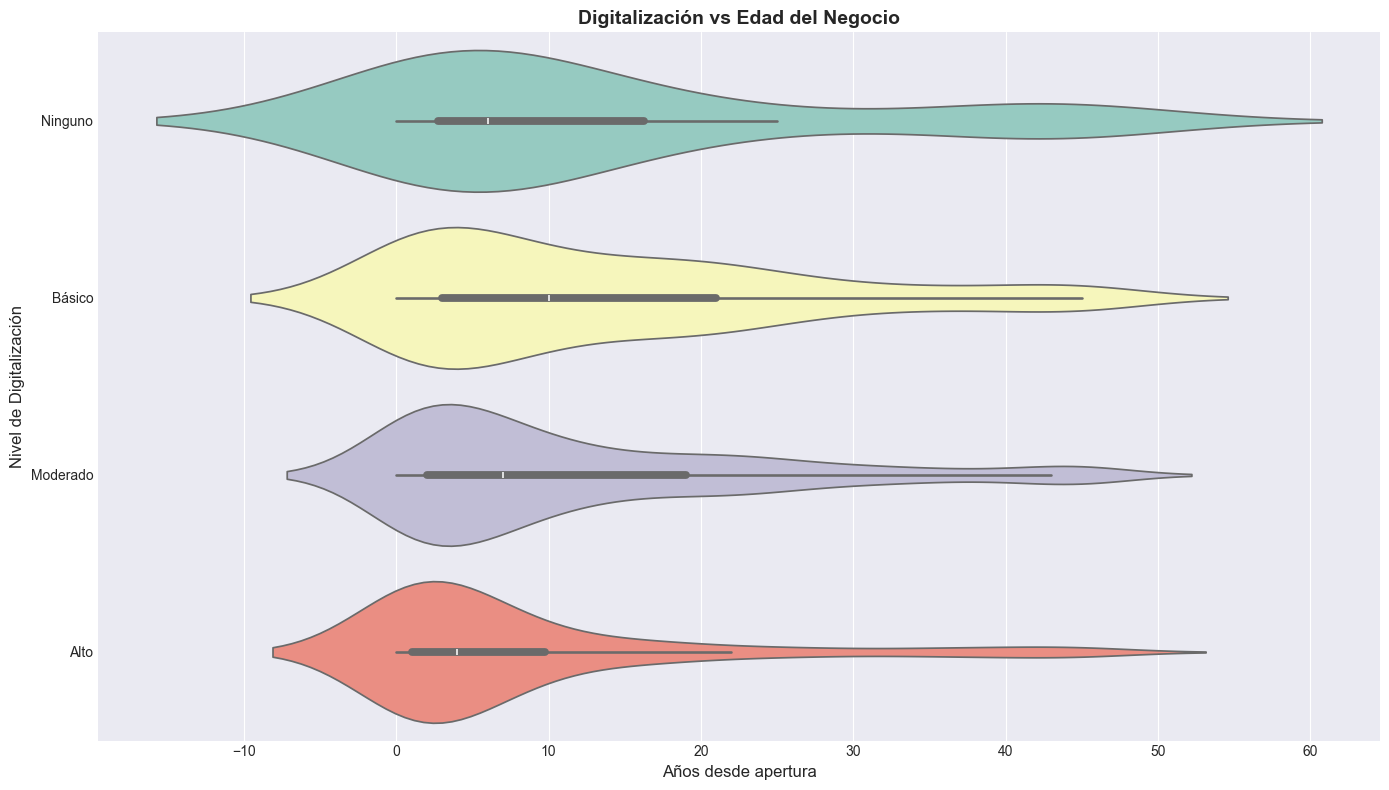

In [23]:
# 7.2.2 Digitalización vs Edad del Negocio
fig, ax = plt.subplots(figsize=(14, 8))

df_plot2 = df[df['nivel_digitalizacion'].notna() & df['edad_negocio'].notna()]
sns.violinplot(data=df_plot2, y='nivel_digitalizacion', x='edad_negocio',
               order=digital_order, ax=ax, palette='Set3')
ax.set_title('Digitalización vs Edad del Negocio', fontsize=14, fontweight='bold')
ax.set_ylabel('Nivel de Digitalización', fontsize=12)
ax.set_xlabel('Años desde apertura', fontsize=12)

# Reemplazar etiquetas del eje Y con versiones cortas
ax.set_yticklabels(digital_labels)

plt.tight_layout()
plt.show()


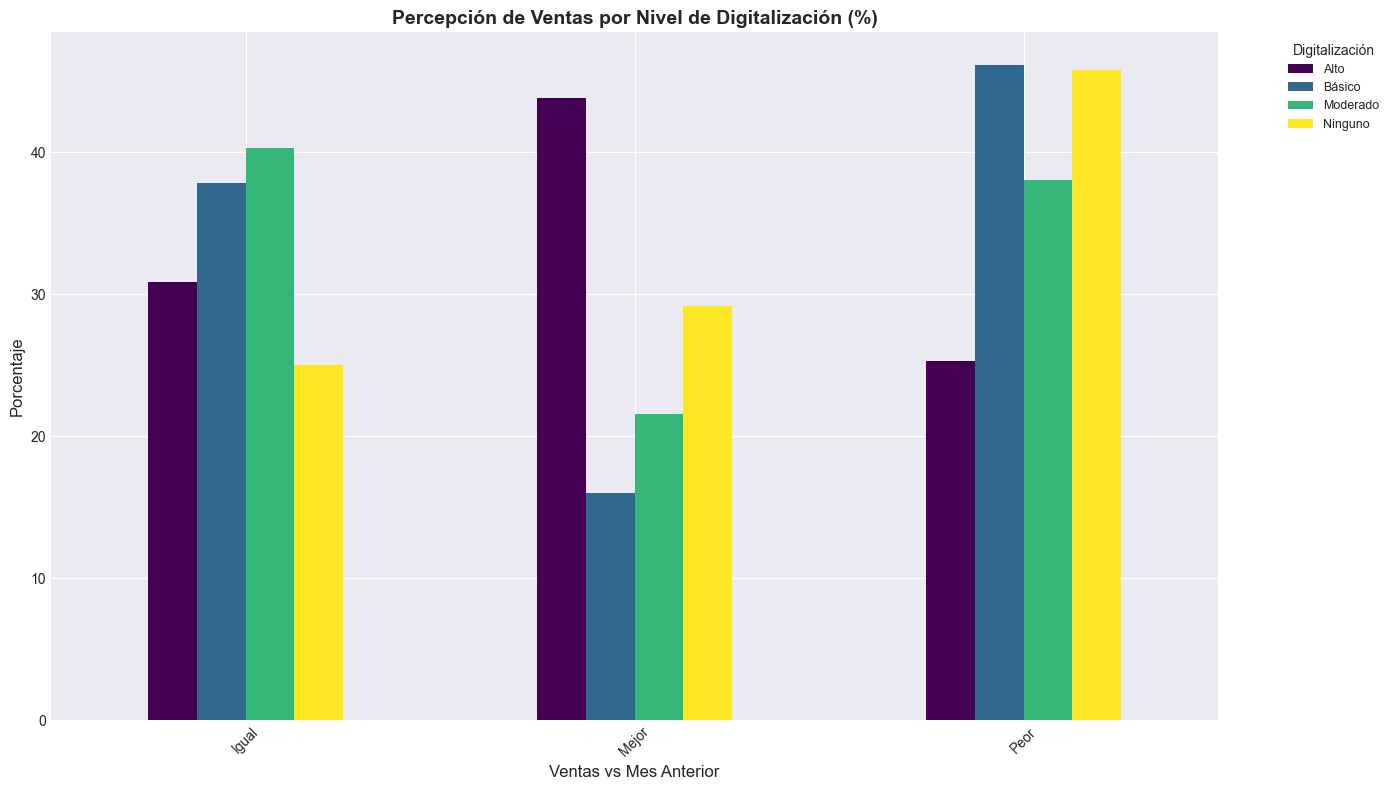

In [24]:
# 7.2.3 Percepción de Ventas por Nivel de Digitalización
fig, ax = plt.subplots(figsize=(14, 8))

# Crear crosstab con nombres originales
ventas_digital = pd.crosstab(df['ventas_vs_mes_anterior'], df['nivel_digitalizacion'], normalize='columns') * 100

# Crear mapeo de nombres largos a cortos para las columnas
column_mapping = {}
for col in ventas_digital.columns:
    if 'Ninguno' in str(col):
        column_mapping[col] = 'Ninguno'
    elif 'Básico' in str(col) or 'básico' in str(col):
        column_mapping[col] = 'Básico'
    elif 'Moderado' in str(col):
        column_mapping[col] = 'Moderado'
    elif 'Alto' in str(col):
        column_mapping[col] = 'Alto'
    else:
        column_mapping[col] = str(col)

ventas_digital = ventas_digital.rename(columns=column_mapping)

ventas_digital.plot(kind='bar', ax=ax, colormap='viridis')
ax.set_title('Percepción de Ventas por Nivel de Digitalización (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Porcentaje', fontsize=12)
ax.set_xlabel('Ventas vs Mes Anterior', fontsize=12)
ax.legend(title='Digitalización', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


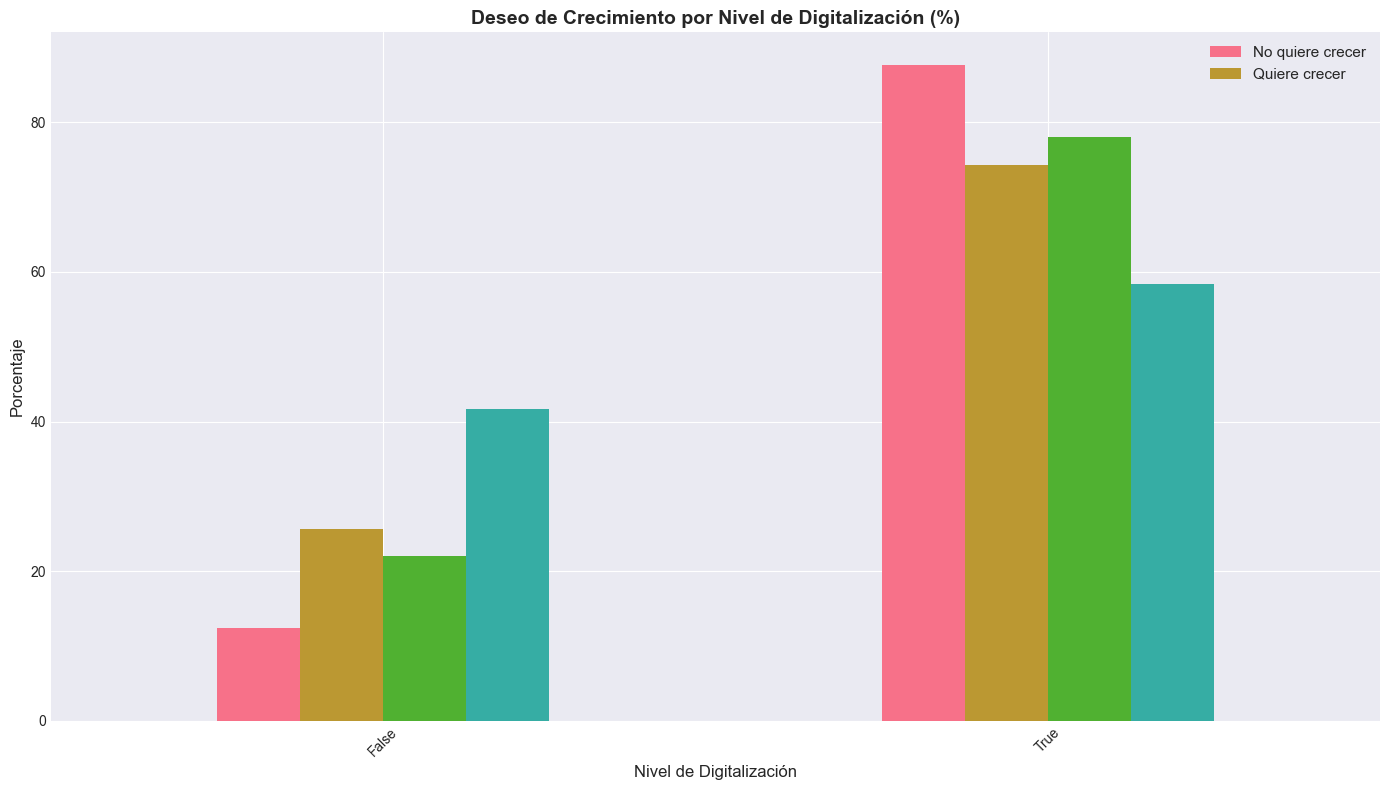

In [25]:
# 7.2.4 Deseo de Crecimiento por Nivel de Digitalización
fig, ax = plt.subplots(figsize=(14, 8))

crecer_digital = pd.crosstab(df['quiere_crecer'], df['nivel_digitalizacion'], normalize='columns') * 100
crecer_digital.plot(kind='bar', ax=ax)
ax.set_title('Deseo de Crecimiento por Nivel de Digitalización (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Porcentaje', fontsize=12)
ax.set_xlabel('Nivel de Digitalización', fontsize=12)
ax.legend(['No quiere crecer', 'Quiere crecer'], title='', loc='upper right', fontsize=11)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Tests de hipótesis

In [26]:
# Test Chi-cuadrado: Digitalización vs Deseo de Crecimiento
df_temp_test = df.copy()
df_temp_test['nivel_digital_resumido'] = df_temp_test['nivel_digitalizacion'].apply(resumir_digitalizacion)

contingency_table = pd.crosstab(df_temp_test['nivel_digital_resumido'].fillna('Sin datos'), 
                                df_temp_test['quiere_crecer'].fillna('Sin datos'))

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Test Chi-cuadrado: Digitalización vs Deseo de Crecimiento")
print(f"Chi-cuadrado: {chi2:.4f}")
print(f"p-valor: {p_value:.6f}")
print(f"Grados de libertad: {dof}")

Test Chi-cuadrado: Digitalización vs Deseo de Crecimiento
Chi-cuadrado: 850.0580
p-valor: 0.000000
Grados de libertad: 8


El test de chi-cuadrado es apropiado para evaluar la independencia entre dos variables categóricas. En este caso, buscamos determinar si existe una relación estadística entre el nivel de digitalización de un negocio y su deseo de crecer. La hipótesis nula plantea que ambas variables son independientes. Con un p-valor significativamente menor a 0.05, rechazamos la hipótesis nula, lo que indica que existe una asociación estadísticamente significativa entre el nivel de digitalización y el deseo de crecimiento. Este hallazgo sugiere que la digitalización podría estar relacionada con una mentalidad más orientada al crecimiento empresarial, aunque la causalidad no puede establecerse con este test.

In [27]:
# Test t de Student: Trabajadores vs Deseo de Crecimiento
grupo_quiere_crecer = df[df['quiere_crecer'] == True]['trabajadores_total'].dropna()
grupo_no_quiere_crecer = df[df['quiere_crecer'] == False]['trabajadores_total'].dropna()

t_stat, p_value = stats.ttest_ind(grupo_quiere_crecer, grupo_no_quiere_crecer)

print("Test t de Student: Trabajadores según Deseo de Crecimiento")
print(f"Grupo que quiere crecer: n={len(grupo_quiere_crecer)}, media={grupo_quiere_crecer.mean():.2f}, std={grupo_quiere_crecer.std():.2f}")
print(f"Grupo que no quiere crecer: n={len(grupo_no_quiere_crecer)}, media={grupo_no_quiere_crecer.mean():.2f}, std={grupo_no_quiere_crecer.std():.2f}")
print(f"Estadístico t: {t_stat:.4f}")
print(f"p-valor: {p_value:.6f}")

Test t de Student: Trabajadores según Deseo de Crecimiento
Grupo que quiere crecer: n=660, media=3.26, std=2.15
Grupo que no quiere crecer: n=181, media=2.83, std=2.15
Estadístico t: 2.3939
p-valor: 0.016890


El test t de Student compara las medias de dos grupos independientes cuando las variables siguen una distribución aproximadamente normal. Aquí comparamos el número promedio de trabajadores entre negocios que desean crecer y los que no. La hipótesis nula establece que no hay diferencia entre las medias. El p-valor obtenido indica que existe una diferencia estadísticamente significativa, sugiriendo que los negocios con más trabajadores tienden a mostrar mayor interés en el crecimiento. Esta diferencia podría reflejar que empresas con mayor capacidad operativa tienen más recursos y confianza para expandirse.

In [28]:
# ANOVA: Edad del negocio según Tipo de Negocio
tipo_counts = df['tipo_negocio'].value_counts()
tipos_validos = tipo_counts[tipo_counts >= 10].index[:5]

grupos = []
for tipo in tipos_validos:
    grupo = df[df['tipo_negocio'] == tipo]['edad_negocio'].dropna()
    grupos.append(grupo)
    print(f"{tipo}: n={len(grupo)}, media={grupo.mean():.2f}, std={grupo.std():.2f}")

f_stat, p_value = stats.f_oneway(*grupos)

print(f"\nANOVA: Edad del negocio según Tipo")
print(f"Estadístico F: {f_stat:.4f}")
print(f"p-valor: {p_value:.6f}")

Almacén: n=159, media=12.53, std=13.60
Kiosko: n=155, media=14.14, std=12.21
Confitería o Panadería: n=84, media=13.18, std=14.13
Verdulería: n=75, media=10.84, std=10.52
Dietéticas: n=74, media=9.53, std=11.34

ANOVA: Edad del negocio según Tipo
Estadístico F: 2.0598
p-valor: 0.084778


El análisis de varianza ANOVA es el método adecuado para comparar las medias de más de dos grupos independientes. En este análisis evaluamos si la edad promedio de los negocios varía significativamente según el tipo de establecimiento. La hipótesis nula postula que todas las medias son iguales. El p-valor cercano al umbral de significancia sugiere que no hay evidencia contundente de diferencias sistemáticas en la antigüedad entre los distintos tipos de negocios. Esto implica que factores como el tipo de comercio no determinan necesariamente la longevidad del establecimiento en esta muestra.

In [29]:
# Test Chi-cuadrado: Tipo de Negocio vs Nivel de Digitalización
contingency_digital_tipo = pd.crosstab(df['tipo_negocio'], df['nivel_digital_resumido'])
contingency_digital_tipo = contingency_digital_tipo.loc[contingency_digital_tipo.sum(axis=1) >= 20]

chi2_dt, p_value_dt, dof_dt, _ = stats.chi2_contingency(contingency_digital_tipo)

print("Test Chi-cuadrado: Tipo de Negocio vs Digitalización")
print(f"Chi-cuadrado: {chi2_dt:.4f}")
print(f"p-valor: {p_value_dt:.6f}")
print(f"Grados de libertad: {dof_dt}")

Test Chi-cuadrado: Tipo de Negocio vs Digitalización
Chi-cuadrado: 72.0364
p-valor: 0.000337
Grados de libertad: 36


Este segundo test de chi-cuadrado examina la relación entre el tipo de negocio y el nivel de digitalización adoptado. La pregunta de investigación es si ciertos tipos de comercios tienden a adoptar más tecnologías digitales que otros. Los resultados del test pueden revelar patrones sectoriales en la adopción tecnológica, lo cual sería relevante para políticas de digitalización focalizadas. Si el p-valor es significativo, indicaría que la adopción digital no es homogénea entre sectores, sugiriendo que algunos rubros enfrentan barreras o incentivos diferentes para digitalizar sus operaciones.

In [30]:
# Test Mann-Whitney U: Consumo Energético según Deseo de Crecimiento
consumo_quiere = df[df['quiere_crecer'] == True]['consumo_energia_kw_num'].dropna()
consumo_no_quiere = df[df['quiere_crecer'] == False]['consumo_energia_kw_num'].dropna()

u_stat, p_value_u = stats.mannwhitneyu(consumo_quiere, consumo_no_quiere, alternative='two-sided')

print("Test Mann-Whitney U: Consumo Energético según Deseo de Crecimiento")
print(f"Grupo que quiere crecer: n={len(consumo_quiere)}, mediana={consumo_quiere.median():.2f}")
print(f"Grupo que no quiere crecer: n={len(consumo_no_quiere)}, mediana={consumo_no_quiere.median():.2f}")
print(f"Estadístico U: {u_stat:.4f}")
print(f"p-valor: {p_value_u:.6f}")

Test Mann-Whitney U: Consumo Energético según Deseo de Crecimiento
Grupo que quiere crecer: n=231, mediana=800.00
Grupo que no quiere crecer: n=59, mediana=1012.00
Estadístico U: 6121.0000
p-valor: 0.228001


El test de Mann-Whitney U es la alternativa no paramétrica al test t de Student, apropiado cuando los datos no siguen una distribución normal o presentan valores atípicos extremos. El consumo energético es una variable que típicamente muestra distribuciones asimétricas con valores extremos, por lo que este test es más robusto que el t de Student. Aquí evaluamos si existe diferencia en el consumo energético mediano entre negocios que desean crecer y los que no. Una diferencia significativa sugeriría que los negocios con mayor actividad operativa, reflejada en su consumo energético, tienen diferentes perspectivas de crecimiento.